In [1]:
import numpy as np
import matplotlib.pyplot as plt

Start with an example from our CS course:

Text(0.5, 0, 'Time (s)')

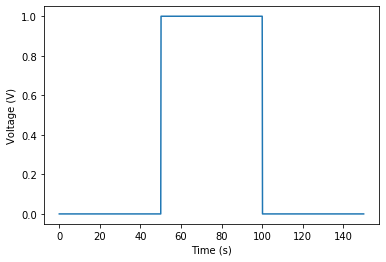

In [2]:
t = np.linspace(0,150,1000)
v = (t > 50) * (t <= 100)

plt.plot(t,v)
plt.ylabel("Voltage (V)")
plt.xlabel("Time (s)")

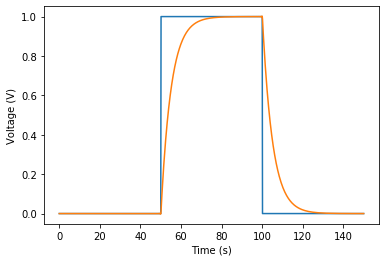

In [4]:
tau = 5
v_t = np.fft.fft(v)
f = np.fft.fftfreq(len(v), d=t[1])
h = 1/(1+1j*2*np.pi*f*tau)
vfilt_t = v_t*h
vfilt = np.real(np.fft.ifft(vfilt_t))

plt.plot(t,v, label="V_{in}")
plt.ylabel("Voltage (V)")
plt.xlabel("Time (s)")
plt.plot(t, vfilt, label="V_{out}");

First, let's take a look at what the inverse transform of h looks like:

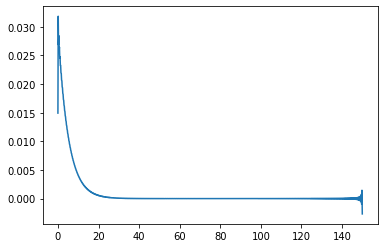

In [5]:
h_inv = np.real(np.fft.ifft(h))
plt.plot(t,h_inv)

Yep, clear, I think that this is what we would expect, aside from the artifacts at the edges, which makes sense from the fact that we are not zero-padding, and that the fft function we are using uses periodic boundary conditions. 

Now, an interesting question: say we wanted our $v_{out}(t)$ to have a step-function form. Given the response of the filter above, what we we need our $v_{in}(t)$ to look like? 

This is easiest to figure out in the Fourier domain! We just need to have:

$$
\tilde v_{in}(\omega) = \frac{\tilde v_{out}(\omega)}{h(\omega)}
$$

(Here I use the notation that $\tilde v(\omega)$ is the FFT of $v(t)$). The answer for v(t) is then just the inverse transform! 

The choice of the $v_{in}(t)$ as above is called "predistortion". 

Let's take a look at what this would look like:

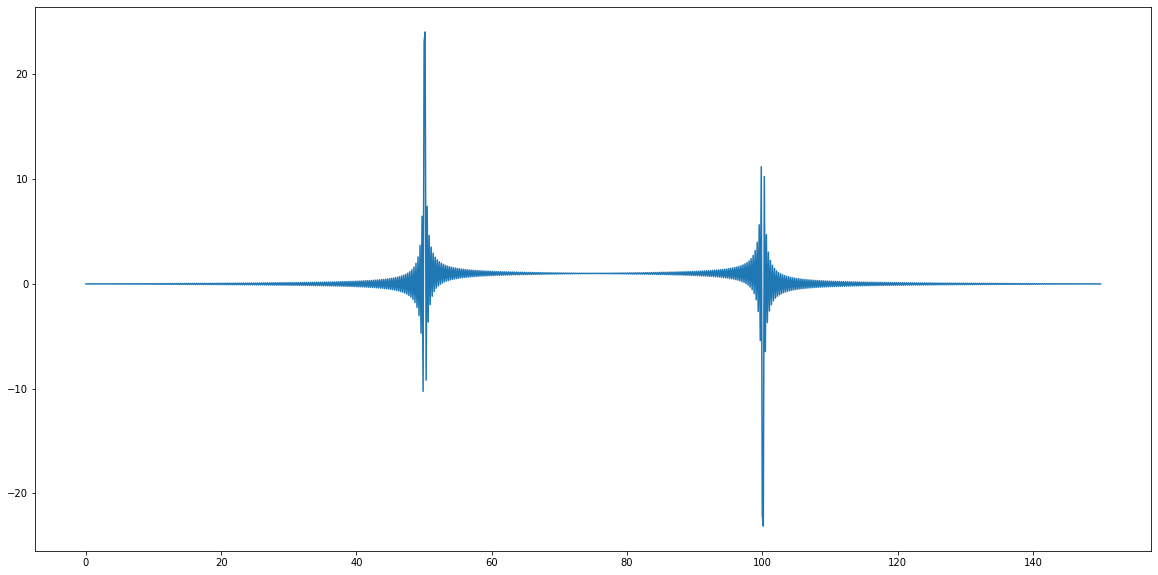

In [10]:
plt.subplots(figsize=(20,10))
v_pre_t = v_t / h
v_pre = np.real(np.fft.ifft(v_pre_t))
plt.plot(t,v_pre)

Hmmm...this has some issues. I think that there are maybe problems due to the edge effects above. Let's try defining our response function first in time domain.

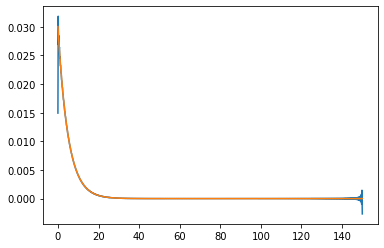

In [24]:
h2_inv = np.exp(-t/5)*t[1]/5
plt.plot(t,h_inv)
plt.plot(t,h2_inv)

Hmmm, I'm not 100% sure where the factor of `t[1]/5` came from. Probably somehow related to the normalisation choice of the inverse fourier transform. (I reverse engineered it by guessing...) Something to figure out at some points. But let's see if this helps with our inverse convolution for the pre-distortion.

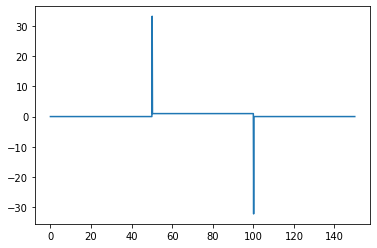

In [31]:
h2 = np.fft.fft(h2_inv)
v_pre_t = v_t / h2
v_pre = np.real(np.fft.ifft(v_pre_t))
plt.plot(t,v_pre)

Yep, that fixes it. The fast oscillations are gone and there is no more imaginary component. Good. The previous result is then clearly came from numerical artifacts from defining the transfer function in the Fourier domain instead of in the time domain. Cool. 

Let's double check for sure that this works:

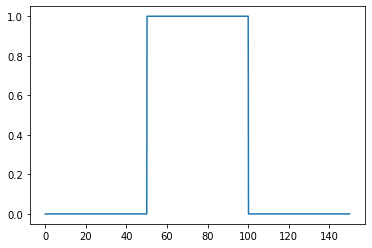

In [34]:
v_out = np.real(np.fft.ifft(np.fft.fft(v_pre)*h2))
plt.plot(t,v_out)

Yep, cool! 

Of course, the challenge is in constructing the needed $v_{pre}(t)$ in practice:


(0, 35)

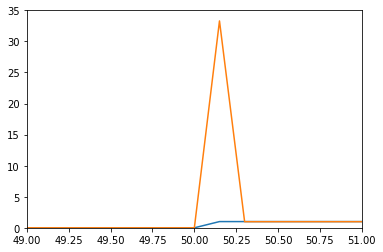

In [40]:
plt.plot(t,v_out)
plt.plot(t,v_pre)
plt.xlim(49,51)
plt.ylim(0,35)


It requires a spike of 33 volts to produce a 1V signal!

But, we can play around with optimising the possible input signals to get the best match to the desired signal. 